In [ ]:
from nb_two_utils import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Installing gensim...
gensim installed.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
spark = configure_env()

Installing Java 8...
Java 8 Installed.
Installing pyspark and spark-nlp...
pyspark and spark-nlp installed.
Starting Spark runtime...
Spark NLP version:  2.4.2
Apache Spark version:  2.4.4
Spark is running.


In [ ]:
import numpy as np
import pandas as pd
import random
import string
import pickle
from functools import partial
from operator import itemgetter
from itertools import combinations
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

In [ ]:
meta = spark.read\
                .option("header", "true")\
                .csv("/content/abstract_data_final_01.csv").drop("_c0")

In [ ]:
meta.printSchema()

root
 |-- cord_uid: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_year: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- url: string (nullable = true)
 |-- word_count: string (nullable = true)
 |-- raw_abstract: string (nullable = true)
 |-- keywords: string (nullable = true)



In [ ]:
print("Record count: ", meta.count())

Record count:  112187


In [ ]:
stop_words = process_corpus('stop_words.pkl')
corpus = process_corpus('open_covid_corpus.pkl')

In [ ]:
print(f"Length of corpus: {len(corpus)}")

Length of corpus: 112187


In [ ]:
get_tokens = partial(process_text, stop_words=stop_words)
getTokensUDF = udf(get_tokens, ArrayType(StringType()))
meta = meta.withColumn("tokens", getTokensUDF(meta["raw_abstract"]))
meta.printSchema()

root
 |-- cord_uid: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_year: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- url: string (nullable = true)
 |-- word_count: string (nullable = true)
 |-- raw_abstract: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
meta.show(5)

+--------+--------------------+--------------------+---------+--------------------+------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|cord_uid|            source_x|               title|  license|            abstract|publish_year|             authors|             journal|                 url|word_count|        raw_abstract|            keywords|              tokens|
+--------+--------------------+--------------------+---------+--------------------+------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|00a19z5i|['Elsevier', ' Me...|Testing the modul...|els-covid|Abstract The N-te...|        2006|['Teterina Nataly...|            Virology|https://www.scien...|       207|Abstract Ntermina...|['rna', 'ntermina...|[abstract, ntermi...|
|02rcmt0g|         ['Medline']|Activation of Egr...|      unk|Hu

In [ ]:
%time token_list = meta.rdd.map(lambda x : x['tokens']).collect()
#token_list[0]

CPU times: user 1.62 s, sys: 409 ms, total: 2.03 s
Wall time: 2min 25s


In [ ]:
# Flaten the list of lists
p_text = [item for sublist in token_list for item in sublist]

In [ ]:
# Top 20
top_20 = get_freq_words(p_text, k=20)
top_20

,word,frequency
0,patient,138835
1,use,100367
2,infect,93825
3,studi,89880
4,virus,87430
5,covid,75505
6,result,71517
7,diseas,71408
8,cell,56063
9,method,47238


In [ ]:
num_unique_words = len(set(p_text))
print("No. of unique words in corpus: ", num_unique_words)

No. of unique words in corpus:  191409


In [ ]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(10, 50 + 1, 10))

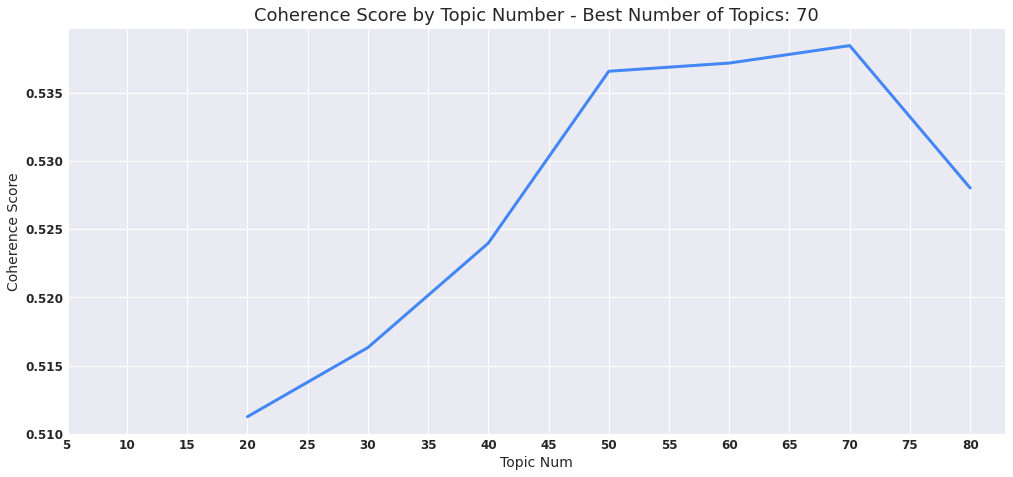

In [ ]:
# Plot the results
# for each number of topics
'''
gensim_corpus = [dictionary.doc2bow(text) for text in token_list]
coherence_scores = []
for num in tqdm(topic_nums):
    nmf = Nmf(
        corpus=gensim_corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=10000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )

    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=token_list,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums.collect()),   coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
plot_coherence(coherence_scores, best_num_topics, topic_nums, 'topic_coherence.png')
'''

In [ ]:
tfidf_vect = TfidfVectorizer(max_df=0.95, min_df=3, ngram_range=(1, 4), stop_words=stop_words)
A = tfidf_vect.fit_transform(corpus)
tfidf_fn = tfidf_vect.get_feature_names()

In [ ]:
#topic_models= get_coherence_scores(kmin=10, kmax=50, step=10, A=A)

In [ ]:
%time nmf = NMF(n_components=35,init='nndsvd', \
                max_iter=500,\
                l1_ratio=0.0, \
                solver='cd', \
                alpha=0.0, \
                tol=1e-4, \
                random_state=42).fit(A)

CPU times: user 15min 59s, sys: 17.6 s, total: 16min 17s
Wall time: 15min 51s


In [ ]:
%time docweights = nmf.transform(tfidf_vect.transform(corpus))

CPU times: user 58.7 s, sys: 22.9 ms, total: 58.7 s
Wall time: 58.7 s


In [ ]:
topic_table(nmf, tfidf_fn, 35).head(35)

,topic_0:,topic_1:,topic_2:,topic_3:,topic_4:,topic_5:,topic_6:,topic_7:,topic_8:,topic_9:,topic_10:,topic_11:,topic_12:,topic_13:,topic_14:,topic_15:,topic_16:,topic_17:,topic_18:,topic_19:,topic_20:,topic_21:,topic_22:,topic_23:,topic_24:,topic_25:,topic_26:,topic_27:,topic_28:,topic_29:,topic_30:,topic_31:,topic_32:,topic_33:,topic_34:
0,patients,cells,covid19,sarscov2,children,sars,protein,covid 19,model,group,laparoscopic,detection,influenza,data,ci,see text,merscov,health,rna,stroke,lung,studies,pedv,care,antiviral,viruses,ibv,cases,ct,cats,ace2,diseases,mesh,calves,vaccine
1,clinical,cell,pandemic,coronavirus,respiratory,cov,proteins,covid,epidemic,groups,surgery,samples,influenza virus,learning,risk,formula see text,middle east,public,replication,aneurysms,ards,review,porcine,healthcare,activity,virus,strains,china,ablation,feline,angiotensin,infectious,hernia,diarrhea,vaccines
2,hospital,infection,covid19 pandemic,acute respiratory syndrome coronavirus,rsv,sarscov,fusion,19,social,vs,surgical,assay,h1n1,model,factors,formula see,east,public health,genome,endovascular,ventilation,systematic,diarrhea,health care,drug,viral,gene,confirmed,imaging,fip,receptor,disease,repair,bovine,immune
3,treatment,expression,disease covid19,severe acute respiratory,infections,sars cov,membrane,sars cov,measures,significantly,postoperative,pcr,virus,models,associated,formula,middle,global,viral,aneurysm,respiratory,trials,pigs,pandemic,drugs,host,strain,case,rfa,fcov,enzyme,infectious diseases,hernia repair,rotavirus,antibodies
4,days,mice,disease,severe acute,respiratory tract,severe acute respiratory,binding,cov,distancing,compared,complications,positive,pandemic,paper,mortality,text,east respiratory,mental,rnas,artery,pulmonary,evidence,porcine epidemic,workers,compounds,human,isolates,number,tumor,dogs,expression,pathogens,pain,calf,antibody
5,covid19 patients,immune,coronavirus disease covid19,acute respiratory syndrome,tract,severe acute,sarscov,19 pandemic,transmission,control,technique,rtpcr,influenza viruses,method,age,see,middle east respiratory,mental health,viral rna,occlusion,acute,systematic review,epidemic diarrhea,medical,treatment,species,sequence,countries,chest,fipv,ace,emerging,inguinal,coli,responses
6,symptoms,response,coronavirus,severe,hmpv,acute respiratory syndrome,domain,covid 19 pandemic,social distancing,control group,procedure,sensitivity,avian,information,risk factors,text formula,east respiratory syndrome,international,synthesis,treatment,respiratory distress,quality,porcine epidemic diarrhea,staff,inhibitors,bats,infectious bronchitis,deaths,liver,cat,ras,infectious disease,recurrence,samples,vaccination
7,median,activation,coronavirus disease,severe acute respiratory syndrome,respiratory viruses,severe acute respiratory syndrome,spike,disease covid,spread,study,resection,assays,avian influenza,network,higher,text formula see text,middle east respiratory syndrome,social,rna viruses,stent,injury,included,piglets,patient,protease,bat,bronchitis,reported,lesions,peritonitis,angiotensinconverting,human,hernias,cattle,mice
8,icu,responses,covid19 patients,coronavirus sarscov2,infection,respiratory syndrome,amino,disease covid 19,number,significant,performed,testing,h5n1,proposed,study,text formula see,mers,global health,sequence,ischemic,distress,articles,virus pedv,management,therapeutic,replication,sequences,confirmed cases,cancer,feline infectious,angiotensinconverting enzyme,infections,inguinal hernia,dairy,development
9,admission,cd8,covid19 infection,acute respiratory,asthma,syndrome sars,structural,coronavirus disease covid,lockdown,001,operative,test,seasonal,based,ratio,see text formula,respiratory,policy,mrna,intracranial,distress syndrome,literature,epidemic,health,potential,infection,bronchitis virus,wuhan,tumors,infectious peritonitis,ii,animal,fixation,colostrum,neutralizing


In [ ]:
print(len(docweights))

112187


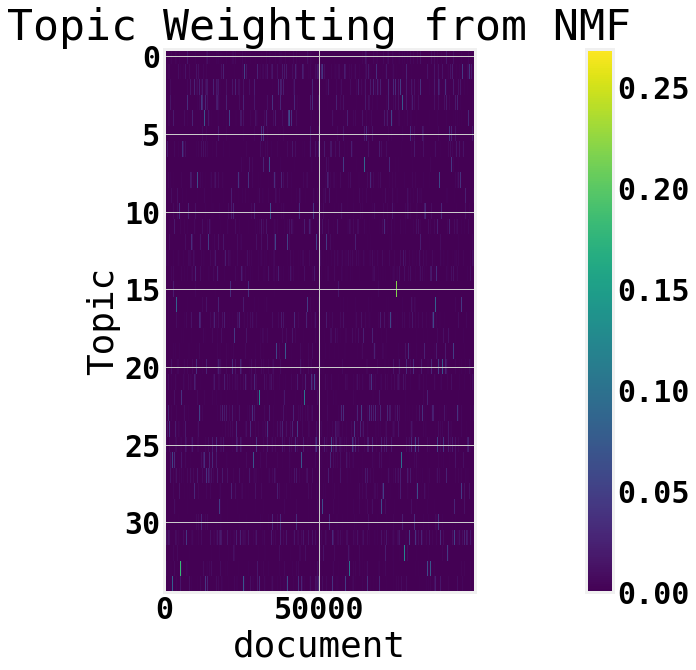

In [ ]:
plt.figure(figsize=(40,10))
plt.style.use('fivethirtyeight')
plt.rc('font', **{'family' : 'monospace',
          'weight' : 'bold',
          'size'   : 30})
plt.imshow(docweights[0:100000, :].T, aspect=5000, interpolation='none')
plt.title('Topic Weighting from NMF')
plt.xlabel('document')
plt.ylabel('Topic')
plt.colorbar()

In [ ]:
#A = tfidf_vect.transform(corpus)
W = nmf.components_
H = nmf.transform(A)

In [ ]:
print('A is {} x {}'.format(*A.shape))
print('W is {} x {}'.format(*W.shape))
print('H is {} x {}'.format(*H.shape))

A is 112187 x 1115514
W is 35 x 1115514
H is 112187 x 35


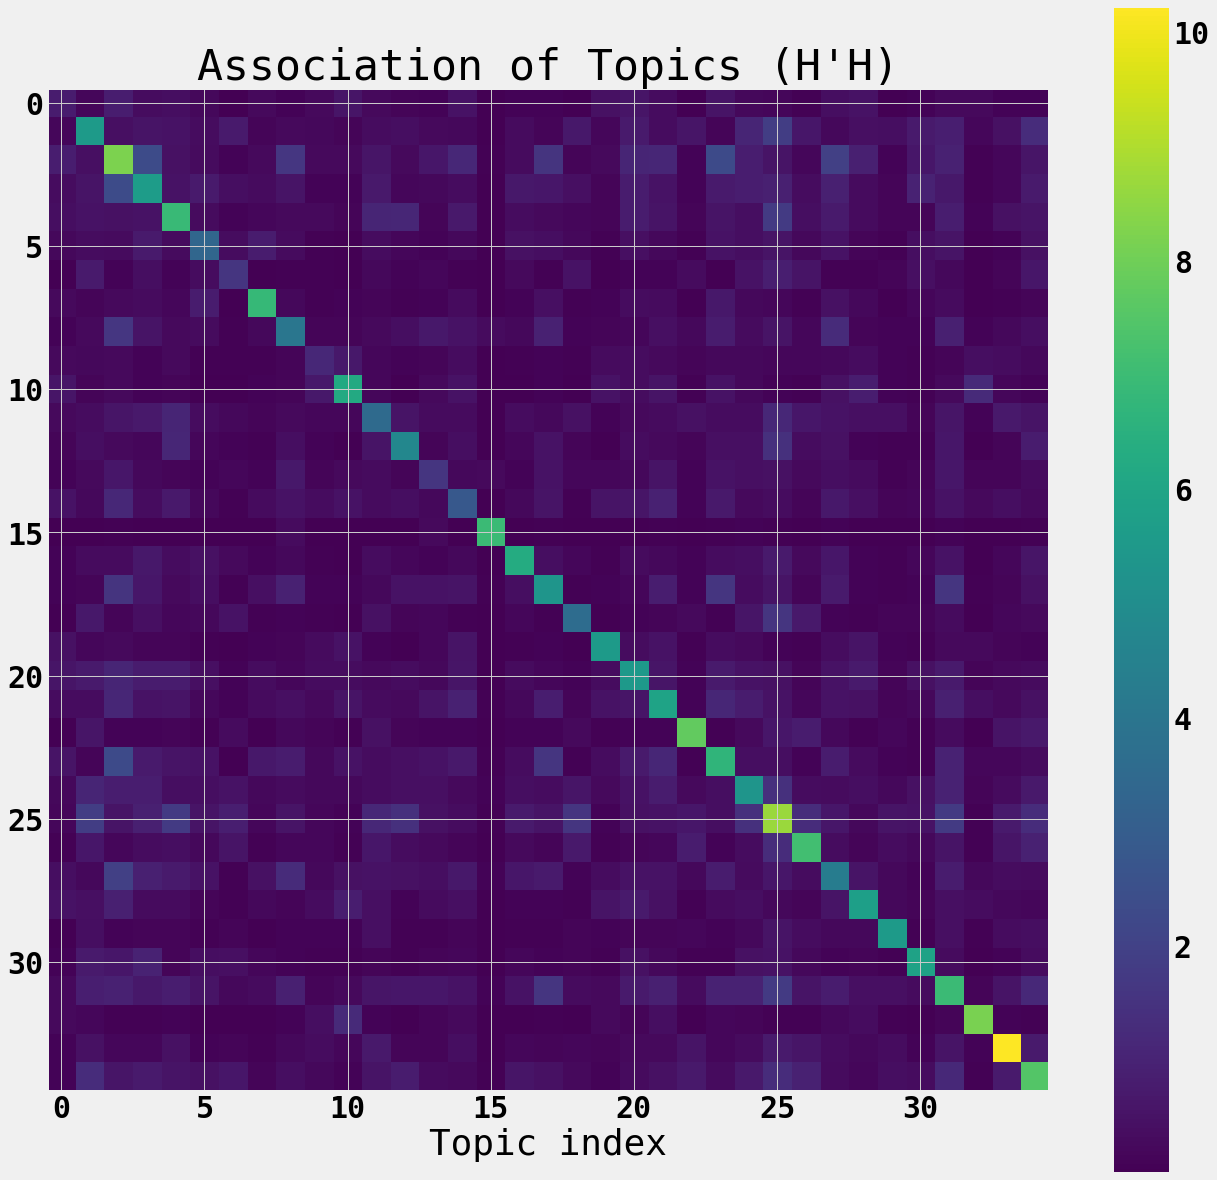

In [ ]:
#sns.set_style('darkgrid')
plot_vector_association(H, "H")

In [ ]:
%%time
r = np.zeros(A.shape[0])
for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :]- H[row,:].dot(W))

CPU times: user 2h 43min 24s, sys: 34min 40s, total: 3h 18min 4s
Wall time: 50min 5s


In [ ]:
print(f"Topic Residual: { sum(np.sqrt(r)) }")
nmf.reconstruction_err_

Topic Residual: 111228.71368855415


329.32788196308144

In [ ]:
n_top_words = 5

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

topic_df = clean_topic_matrix(topic_df)

print(topic_df)

                      0  ...                                             topics
topic_0:       patients  ...          patients clinical hospital treatment days
topic_1:          cells  ...               cells cell infection expression mice
topic_2:        covid19  ...                           covid19 pandemic disease
topic_3:       sarscov2  ...  sarscov2 coronavirus acute respiratory syndrom...
topic_4:       children  ...          children respiratory rsv infections tract
topic_5:           sars  ...          sars cov sarscov severe acute respiratory
topic_6:        protein  ...           protein proteins fusion membrane binding
topic_7:       covid 19  ...                                  covid 19 sars cov
topic_8:          model  ...          model epidemic social measures distancing
topic_9:          group  ...             group groups vs significantly compared
topic_10:  laparoscopic  ...  laparoscopic surgery surgical postoperative co...
topic_11:     detection  ...            

In [ ]:
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']
topic_df

,topic_num,topics
0,topic_0:,patients clinical hospital treatment days
1,topic_1:,cells cell infection expression mice
2,topic_2:,covid19 pandemic disease
3,topic_3:,sarscov2 coronavirus acute respiratory syndrom...
4,topic_4:,children respiratory rsv infections tract
5,topic_5:,sars cov sarscov severe acute respiratory
6,topic_6:,protein proteins fusion membrane binding
7,topic_7:,covid 19 sars cov
8,topic_8:,model epidemic social measures distancing
9,topic_9:,group groups vs significantly compared


In [ ]:
meta.show()

+--------+--------------------+--------------------+---------+--------------------+------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|cord_uid|            source_x|               title|  license|            abstract|publish_year|             authors|             journal|                 url|word_count|        raw_abstract|            keywords|              tokens|
+--------+--------------------+--------------------+---------+--------------------+------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+
|00a19z5i|['Elsevier', ' Me...|Testing the modul...|els-covid|Abstract The N-te...|        2006|['Teterina Nataly...|            Virology|https://www.scien...|       207|Abstract Ntermina...|['rna', 'ntermina...|[abstract, ntermi...|
|02rcmt0g|         ['Medline']|Activation of Egr...|      unk|Hu

In [ ]:
meta = meta.drop("tokens")
meta_p = meta.toPandas()

In [ ]:
meta_p['topic'] = docweights.argmax(axis=1)
meta_p['topic resid'] = r

In [ ]:
meta_p.head()

,cord_uid,source_x,title,license,abstract,publish_year,authors,journal,url,word_count,raw_abstract,keywords,topic,topic resid
0,00a19z5i,"['Elsevier', ' Medline', ' PMC']",Testing the modularity of the N-terminal amphi...,els-covid,Abstract The N-terminal region of the picornav...,2006,"['Teterina Natalya L.', ' Gorbalenya Alexander...",Virology,https://www.sciencedirect.com/science/article/...,207,Abstract Nterminal region picornaviralC protei...,"['rna', 'nterminal', 'region']",18,0.963766
1,02rcmt0g,['Medline'],Activation of Egr-1 expression in astrocytes b...,unk,Human immunodeficiency virus type 1 (HIV-1) Ta...,2011,"['Fan Yan', ' Zou Wei', ' Green Linden A', ' K...",Journal of neuroimmune pharmacology : the offi...,https://doi.org/10.1007/s11481-010-9217-8; htt...,201,Human immunodeficiency virus type HIV1 Tat pla...,"['egr1', 'tat', 'expression']",1,0.994746
2,034w5afv,"['Medline', ' PMC']",Dissolution Advantage of Nitazoxanide Cocrysta...,cc-by,The effect of hydroxypropyl methylcellulose (H...,2019,"['Salas-Zúñiga Reynaldo', ' Rodríguez-Ruiz Chr...",Pharmaceutics,https://www.ncbi.nlm.nih.gov/pubmed/31881696/;...,236,effect hydroxypropyl methylcellulose HPMC meth...,"['dissolution', 'ntz', 'cocrystals']",24,0.997465
3,04uf62g7,['Medline'],Thin-section computed tomography findings in 1...,unk,"Background To date, there has been no computed...",2017,"['Park Chan Kue', ' Kwon Hoon', ' Park Ji Young']",Acta radiologica,https://doi.org/10.1177/0284185116681039; http...,259,"Background date, computed tomography CT evalua...","['ct', 'patients', 'adenovirus']",28,0.977925
4,0bpse3a0,['Medline'],Conducting polymer-solid electrolyte fibrillar...,unk,The non-linear electrical characteristics of a...,2006,"['Erokhin Victor', ' Berzina Tatiana', ' Camor...",Soft matter,https://doi.org/10.1039/b606893f; https://www....,65,nonlinear electrical characteristics polymeric...,"['polymeric', 'based', 'statistical']",13,0.997645


In [ ]:
meta = spark.createDataFrame(meta_p)

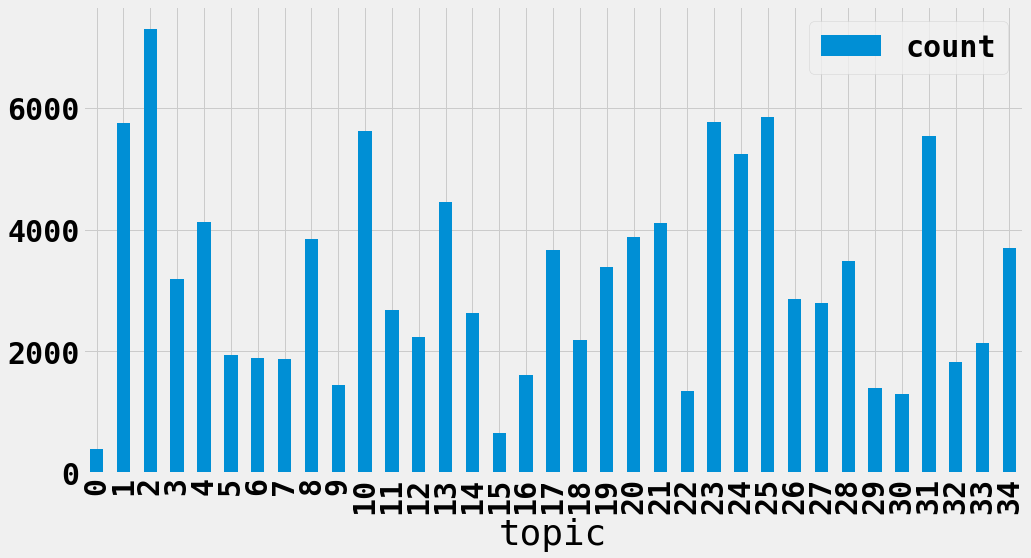

In [ ]:
meta.cache()
meta.groupBy("topic").count().select("topic", "count").toPandas() \
.set_index("topic").sort_index( ascending=True,).plot.bar(figsize=(15,8))

In [ ]:
resid_data = meta.toPandas()[[
    'topic',
    'topic resid'
]].groupby('topic').mean().sort_values(by='topic resid')

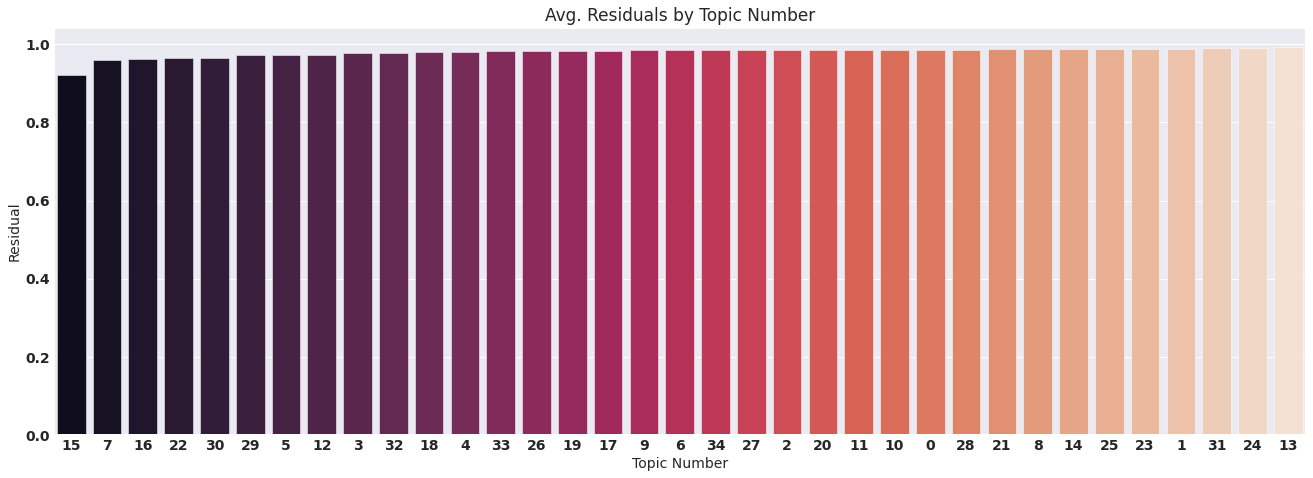

In [ ]:
# Plot a bar chart for the avg. residuls by topic
sns.set_style('darkgrid')
plot_avg_r_per_topic(resid_data)

In [ ]:
meta.show()

+--------+--------------------+--------------------+---------+--------------------+------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+-----+------------------+
|cord_uid|            source_x|               title|  license|            abstract|publish_year|             authors|             journal|                 url|word_count|        raw_abstract|            keywords|topic|       topic resid|
+--------+--------------------+--------------------+---------+--------------------+------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+-----+------------------+
|00a19z5i|['Elsevier', ' Me...|Testing the modul...|els-covid|Abstract The N-te...|        2006|['Teterina Nataly...|            Virology|https://www.scien...|       207|Abstract Ntermina...|['rna', 'ntermina...|    1|0.9720565042739993|
|02rcmt0g|         ['Medline']|Activation of Egr

In [ ]:
'''
label_map = {
    "0": "",
    "1": "", 
    "2": "", 
    "3": "", 
    "4": "", 
    "5": "", 
    "6": "", 
    "7": "", 
    "8": "",
    "9": "", 
    "10": "" 
}
'''

In [ ]:
from sklearn.externals import joblib
joblib.dump((A, docweights), "term_matrix.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['term_matrix.pkl']

In [ ]:
meta.toPandas().to_csv('abstract_data_final_02.csv')

In [ ]:
topic_df.to_csv("topics.csv")